# Stats analysis

## Setup

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
import seaborn as sns

from scipy import stats
import math

from collections import Counter

pd.set_option('precision', 5)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import pingouin as pg



/home/pilmus/thesis/venv37/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.9, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [120]:
experiments = pd.read_csv('../evaluation/resources/2020/all_experiments.csv')  
experiments = experiments.fillna('-')
experiments.subgroup = experiments.subgroup.apply(lambda row: 'none' if row == 'ignore' else row)
experiments.gr = experiments.apply(lambda df: '_'.join([df.group, df.subgroup]) if (df.group != '-' and df.subgroup != '-') else df.group, axis = 1)
experiments['gr'] = experiments.apply(lambda df: '_'.join([df.group, df.subgroup]),axis = 1)
experiments = experiments.drop('util', axis=1)
experiments = experiments.rename({'difference':'difference_h','disparity':'disparity_h','relevance':'relevance_h','difference_ind':'difference_i','disparity_ind':'disparity_i','relevance_ind':'relevance_i'},axis=1)

experiments.ranker = experiments.ranker.apply(lambda row: f'{row}e' if row == 'rfr' else row)
experiments.ranker.value_counts()

/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


ac                  55680
rfre                 9280
lambdamart           2280
relevance_ranker       40
Name: ranker, dtype: int64

### methods

In [4]:
def omega_squared(df_effect, ms_effect, ms_error, ss_total):
    wsq = (df_effect * (ms_effect - ms_error)) / (ss_total - ms_error)
    return wsq
    

In [5]:
def omega_squared_partial(df_effect, ms_effect, ms_error, N):
    wsqp = (df_effect *(ms_effect-ms_error))/(df_effect*ms_effect + (N-df_effect)*ms_error)
    return wsqp

In [6]:
def eta_squared(ss_effect, ss_total, roundd=True):
    if roundd:
        return round(ss_effect/ss_total,5)
    else:
        return ss_effect/ss_total

In [7]:
def eta_squared_partial(ss_effect, ss_error, roundd=True):
    if roundd:
        return round(ss_effect/(ss_effect + ss_error),5)
    else:
        return ss_effect/(ss_effect + ss_error)

In [8]:
def cohens_d(m1, m2, ms_error):
    return abs(m1 - m2) / math.sqrt(ms_error)

In [9]:
def ci(dfe, V, num_observations):
    t = stats.t.ppf(1-0.025, dfe)
    return t*math.sqrt(V/num_observations)

In [10]:
def print_etasq(factor):
    ss_effect = anova_lm(lm).sum_sq.loc[f'C({factor})']
    ss_error = anova_lm(lm).sum_sq.loc['Residual']
    ss_total = anova_lm(lm).sum_sq.sum()

    print(factor)
    
    print(f"eta-squared\teta-squared partial")
    print(f"{eta_squared(ss_effect, ss_total)}\t\t\t{eta_squared_partial(ss_effect, ss_error)}")
    print()

In [11]:
def print_omegasq(anova, factor, N, roundd):
    ms_effect = anova.mean_sq.loc[f'C({factor})']
    ms_error = anova.mean_sq.loc['Residual']
    df_effect = anova.df.loc[f'C({factor})']
    ss_total = anova.sum_sq.sum()
    
    
    print(f"omega-squared\tomega-squared partial")
    print(f"{round(omega_squared(df_effect, ms_effect, ms_error, ss_total),roundd)}\t\t\t{round(omega_squared_partial(df_effect, ms_effect, ms_error, N),roundd)}")
    print()

In [152]:
def plot_levels_anova(anova, data, feature, dv,plotthese=['difference','disparity','relevance'], groupby_order=None):
    plt.rcParams["axes.labelsize"] = 13
    
    ms_error = anova.mean_sq.loc['Residual']
    dfe = anova.df.loc['Residual']
    datasorted = data.sort_values(by=feature)
    if groupby_order:
        
        # Create a dummy df with the required list and the col name to sort on
        dummy = pd.Series(groupby_order, name = feature).to_frame()

        # Use left merge on the dummy to return a sorted df
        datasorted = pd.merge(dummy, datasorted, on = feature, how = 'left')
        
        # datasorted = datasorted[sort_values_like]
    groups = datasorted.groupby(feature)
    means = groups[dv].mean()
    cis = [ci(dfe, ms_error,20)]    *len(groups)

    
#     cis = []
#     for gk, gv in groups.groups.items():
#         m = means[gk]
#         n = len(gv)
#         cis.append(ci(dfe, ms_error,20))
    
    fig, axs = plt.subplots(1,len(plotthese),figsize=(20,10))

    if '_i' in dv:
        addition = '_i'
    elif '_h' in dv:
        addition = '_h'
    elif '_e' in dv:
        addition = '_e'
    else:
        raise ValueError
    

    if len(plotthese) == 1:
        _ = sns.barplot(x=feature, y=f'difference{addition}',ci=None, yerr=cis, data=datasorted,ax=axs)
        _ = axs.bar_label(axs.containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
    
    else:
        # _ = sns.barplot(x=feature, y=f'difference{addition}',ci=None, yerr=cis, data=datasorted,ax=axs[0])
        _ = sns.barplot(x=feature, y=f'difference{addition}', data=datasorted,ax=axs[0])
        _ = axs[0].bar_label(axs[0].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
        if 'disparity' in plotthese:
            _ = sns.barplot(x=feature, y=f'disparity{addition}', ci=None, data=datasorted, ax=axs[1])
            _ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
        if 'relevance' in plotthese:
            _ = sns.barplot(x=feature, y=f'relevance{addition}', ci=None, data=datasorted, ax=axs[2])
            _ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)


In [78]:
def plot_levels_t(V, df, data, feature, dv,plotthese=['difference','disparity','relevance']):
    plt.rcParams["axes.labelsize"] = 13
    
    
    datasorted = data.sort_values(by=feature)
    
    
    
    cis = [ci(df, V,20)]*2
 
    
    fig, axs = plt.subplots(1,len(plotthese),figsize=(20,10))

    if 'ind' in dv:
        addition = '_ind'
    else:
        addition = ''
    
    if len(plotthese) == 1:
        _ = sns.barplot(x=feature, y=f'difference{addition}',ci=None, yerr=cis, data=datasorted,ax=axs)
        _ = axs.bar_label(axs.containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
    
    else:
        _ = sns.barplot(x=feature, y=f'difference{addition}',ci=None, yerr=cis, data=datasorted,ax=axs[0])
        _ = axs[0].bar_label(axs[0].containers[1], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
    if 'disparity' in plotthese:
        _ = sns.barplot(x=feature, y=f'disparity{addition}', ci=None, data=datasorted, ax=axs[1])
        _ = axs[1].bar_label(axs[1].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)
    if 'relevance' in plotthese:
        _ = sns.barplot(x=feature, y=f'relevance{addition}', ci=None, data=datasorted, ax=axs[2])
        _ = axs[2].bar_label(axs[2].containers[0], label_type = 'center', fmt="%.2f", color='white', fontsize=13)


In [79]:
def sample_mean(a,b):
    return (a-b).mean()

In [80]:
def bigV(a,b):
    sm = sample_mean(a,b)
    return (((a-b) - sm)**2).sum()/(len(a) - 1)

# Statistical analysis LM

## Select LambdaMart data

In [81]:
lambdata = experiments[experiments.ranker == 'lambdamart']
lambdata = lambdata.reset_index(drop=True)
lambdata

,difference_h,disparity_h,relevance_h,difference_i,difference_i,relevance_i,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
0,0.21168,1.96463,1.43316,1.68645,1.32943,0.04198,3462,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1,-_-
1,1.07183,2.17346,0.99640,1.90473,1.32943,0.10384,8940,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1,-_-
2,0.69834,3.45495,1.98301,1.53864,1.31771,0.06697,10795,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1,-_-
3,0.80910,1.65976,0.75591,1.46067,1.32943,0.01519,12073,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1,-_-
4,0.24675,2.39058,1.93819,2.07945,1.33332,0.01797,12096,lambdamart,-,-,-,-,-,aug0.5,err,mpt,10,0.1,-_-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,0.71886,3.09551,1.74605,1.76113,1.33327,0.00656,64062,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,-_-
2276,0.01131,2.15078,1.99585,0.52595,1.08236,0.66969,66637,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,-_-
2277,0.01039,1.77589,1.73610,0.59773,1.08333,0.63429,67404,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,-_-
2278,0.52623,1.54197,0.97068,1.75083,1.31769,0.17458,70673,lambdamart,-,-,-,-,-,-,ndcg,-,-,-,-_-


## Relevance

### Augmentation

In [82]:
augdata = lambdata.query('val_metric == "ndcg" and feature_method == "-"')

##### ANOVA

In [83]:
formula = "difference_h ~ C(augmentation) + C(qid)"
lm = ols(formula, augdata).fit()
lm.summary()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(augmentation),2.00000,0.07726,0.03863,0.32185,0.72677
C(qid),19.00000,24.75159,1.30272,10.85339,0.00000
Residual,38.00000,4.56108,0.12003,NaN,NaN


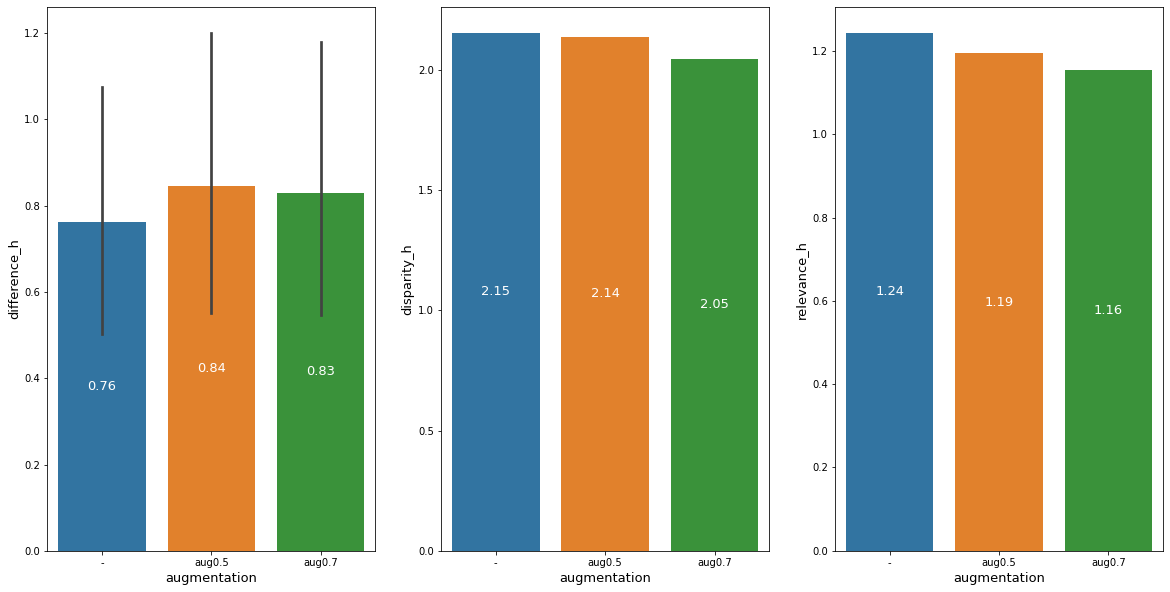

In [84]:
plot_levels_anova(anova,augdata,'augmentation','difference_h')

In [76]:
formula = "difference_ind ~ C(augmentation) + C(qid)"
lm = ols(formula, augdata).fit()
lm.summary()
anova = anova_lm(lm)
anova

PatsyError: Error evaluating factor: NameError: name 'difference_ind' is not defined
    difference_ind ~ C(augmentation) + C(qid)
    ^^^^^^^^^^^^^^

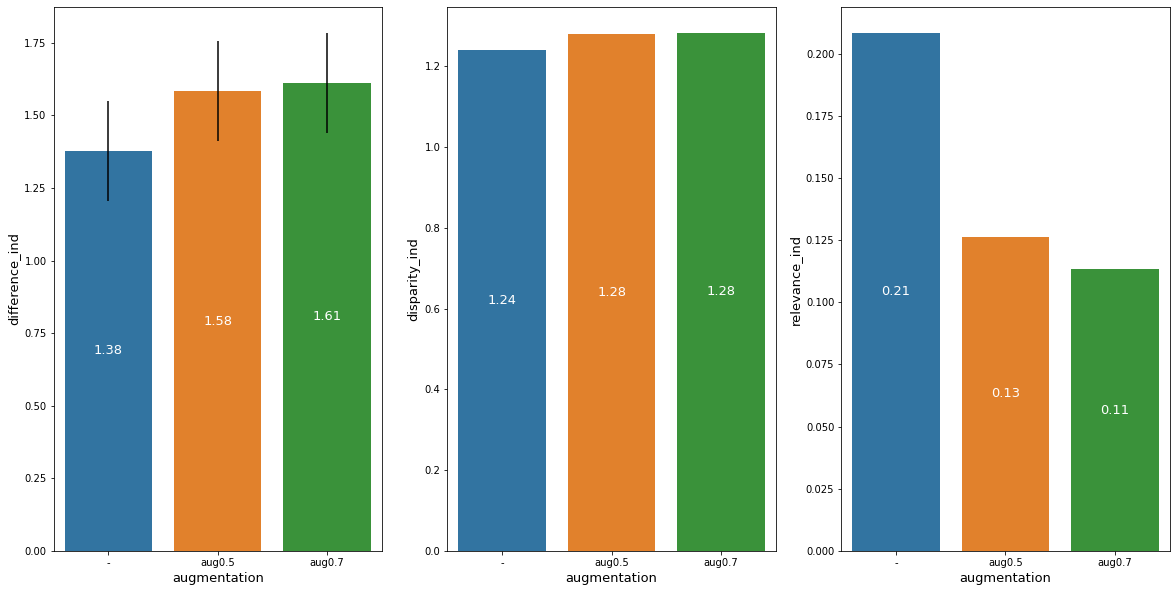

In [21]:
plot_levels_anova(anova,augdata,'augmentation','difference_ind')

### Feature selection

In [22]:
featdata = lambdata.query('val_metric == "ndcg" and augmentation == "-"')

In [23]:
featdata['mrgd'] = featdata.apply(lambda row: '_'.join([row.feature_method, row.num_features, row.balancing_factor]),axis=1)

/home/pilmus/thesis/venv37/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


##### ANOVA

In [24]:
formula = "difference ~ C(feature_method) + C(qid)"
lm = ols(formula, featdata).fit()
lm.summary()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(feature_method),2.00000,0.04583,0.02292,0.07379,0.92889
C(qid),19.00000,66.37992,3.49368,11.24833,0.00000
Residual,358.00000,111.19313,0.31060,NaN,NaN


In [25]:
formula = "difference_ind ~ C(feature_method) + C(qid)"
lm = ols(formula, featdata).fit()
lm.summary()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(feature_method),2.00000,0.04640,0.02320,0.14280,0.86698
C(qid),19.00000,37.47697,1.97247,12.13941,0.00000
Residual,358.00000,58.16964,0.16249,NaN,NaN


### Opt metric

In [26]:
mdata = lambdata.query('feature_method == "-" and augmentation == "-"')

In [27]:
a = mdata.query('val_metric == "ndcg"').difference.reset_index(drop=True)

In [28]:
b = mdata.query('val_metric == "err"').difference.reset_index(drop=True)

In [29]:
pg.ttest(a, b, paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-1.53412,19,two-sided,0.14148,"[-0.33, 0.05]",0.18823,0.635,0.12590


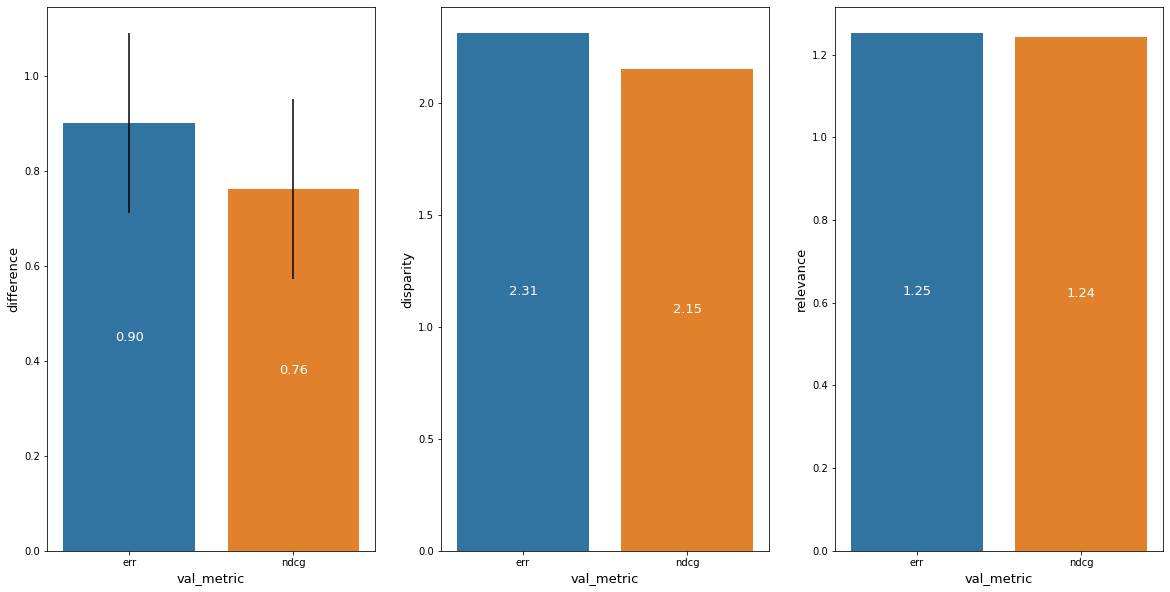

In [30]:
plot_levels_t(bigV(a,b),19,mdata,'val_metric','difference')

In [31]:
a = mdata.query('val_metric == "ndcg"').difference_ind.reset_index(drop=True)

In [32]:
b = mdata.query('val_metric == "err"').difference_ind.reset_index(drop=True)

In [33]:
pg.ttest(a, b, paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-0.92130,19,two-sided,0.36844,"[-0.2, 0.08]",0.11533,0.338,0.07795


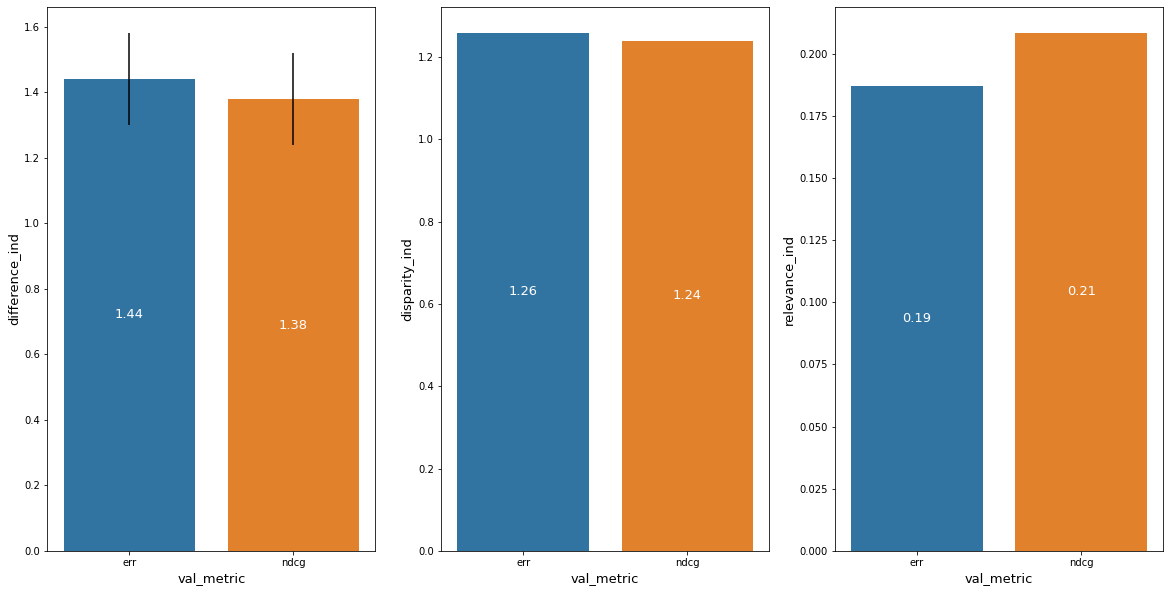

In [34]:
plot_levels_t(bigV(a,b),19,mdata,'val_metric','difference_ind')

## LM post-processing

In [143]:
experiments

,difference_h,disparity_h,relevance_h,difference_i,disparity_i,relevance_i,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
0,0.09399,1.76431,1.39184,0.50547,0.18796,0.06174,3462,ac,lambdamart_aug0.5_err_mpt_10_0.1,author,ind,99.00000,linear,aug0.5,err,mpt,10,0.1,author_ind
1,0.45824,1.34902,0.89097,0.86125,0.50421,0.21297,8940,ac,lambdamart_aug0.5_err_mpt_10_0.1,author,ind,99.00000,linear,aug0.5,err,mpt,10,0.1,author_ind
2,0.21175,2.20588,1.60176,0.37645,0.20089,0.08965,10795,ac,lambdamart_aug0.5_err_mpt_10_0.1,author,ind,99.00000,linear,aug0.5,err,mpt,10,0.1,author_ind
3,0.20305,1.05926,0.75869,0.26930,0.18777,0.04005,12073,ac,lambdamart_aug0.5_err_mpt_10_0.1,author,ind,99.00000,linear,aug0.5,err,mpt,10,0.1,author_ind
4,0.11957,1.87579,1.74439,0.80378,0.28136,0.12983,12096,ac,lambdamart_aug0.5_err_mpt_10_0.1,author,ind,99.00000,linear,aug0.5,err,mpt,10,0.1,author_ind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67275,0.34180,2.19984,1.48675,0.85813,1.08333,0.33309,64062,relevance_ranker,TEXT,-,-,-,-,-,-,-,-,-,-_-
67276,0.32117,3.71522,2.62314,1.88697,1.32937,0.11269,66637,relevance_ranker,TEXT,-,-,-,-,-,-,-,-,-,-_-
67277,0.01885,2.07322,1.88053,0.52595,1.08236,0.66969,67404,relevance_ranker,TEXT,-,-,-,-,-,-,-,-,-,-_-
67278,1.01241,2.37717,1.14519,2.08095,1.33333,0.01734,70673,relevance_ranker,TEXT,-,-,-,-,-,-,-,-,-,-_-


In [144]:
experiments.ranker.value_counts()

ac                  55680
rfre                 9280
lambdamart           2280
relevance_ranker       40
Name: ranker, dtype: int64

In [145]:
ppdata = experiments.query('((ranker == "lambdamart" and source == "-" and augmentation == "-" and feature_method == "-" and val_metric == "ndcg") or (ranker == "rfre" and source == "lambdamart_noaug_ndcg_nofeat" and group=="author" and subgroup=="none") or (ranker == "ac" and source == "lambdamart_noaug_ndcg_nofeat" and hfunc == "linear" and gr == "author_none" and theta == 9))')
ppdata = ppdata.reset_index(drop=True)
ppdata = ppdata[['difference_i','disparity_i','relevance_i','difference_h','disparity_h','relevance_h','qid','source','theta','hfunc','ranker','gr']]
ppdata = ppdata.rename({'gr':'group'},axis=1)
ppdata['group'] = ppdata.group.apply(lambda row: row.replace('_-',''))
# ppdata['ranker'] = ppdata.apply(lambda row: '_'.join([row.ranker, str(row.theta)]).replace('_-',''),axis = 1)

ppdata.ranker = ppdata.ranker.apply(lambda row: 'base' if row == 'lambdamart' else row)

ppdata.head()

,difference_i,disparity_i,relevance_i,difference_h,disparity_h,relevance_h,qid,source,theta,hfunc,ranker,group
0,0.42183,0.13194,0.07555,0.12558,1.81614,1.40197,3462,lambdamart_noaug_ndcg_nofeat,9.00000,linear,ac,author_none
1,0.70721,0.37100,0.22339,0.76783,1.81553,0.96944,8940,lambdamart_noaug_ndcg_nofeat,9.00000,linear,ac,author_none
2,0.43046,0.20536,0.06488,0.22669,1.85391,1.41831,10795,lambdamart_noaug_ndcg_nofeat,9.00000,linear,ac,author_none
3,0.09658,0.10259,0.08381,0.06271,0.91117,0.75481,12073,lambdamart_noaug_ndcg_nofeat,9.00000,linear,ac,author_none
4,0.75770,0.24510,0.13473,0.26299,1.39140,1.43049,12096,lambdamart_noaug_ndcg_nofeat,9.00000,linear,ac,author_none


In [146]:
ppdata.ranker.value_counts()

ac      20
base    20
rfre    20
Name: ranker, dtype: int64

In [147]:
with pd.option_context('precision', 3):
   print( ppdata.drop(['source','theta','hfunc','group'],axis=1).groupby('ranker').mean().round(3)[['difference_i','disparity_i','relevance_i','difference_h','disparity_h','relevance_h']].reset_index())

  ranker  difference_i  disparity_i  relevance_i  difference_h  disparity_h  relevance_h
0     ac       0.45900      0.23300      0.16500       0.40900      1.61500      1.15000
1   base       1.37800      1.23900      0.20800       0.76200      2.15400      1.24300
2   rfre       0.55400      0.30100      0.15100       0.49500      1.65600      1.12700


### EEL

#### ANOVA

In [148]:
formula = "difference_h ~ C(ranker) + C(qid)"
lm = ols(formula, ppdata).fit()
lm.summary()
anova = anova_lm(lm)
with pd.option_context('precision', 2):
    print(anova.round(2))

                df   sum_sq  mean_sq        F  PR(>F)
C(ranker)  2.00000  1.35000  0.68000  9.56000 0.00000
C(qid)    19.00000 18.16000  0.96000 13.49000 0.00000
Residual  38.00000  2.69000  0.07000      NaN     NaN


In [149]:
print_omegasq(anova,'ranker',20,2)
print_omegasq(anova,'qid',3,2)

omega-squared	omega-squared partial
0.05			0.46

omega-squared	omega-squared partial
0.76			0.99



#### Visualize

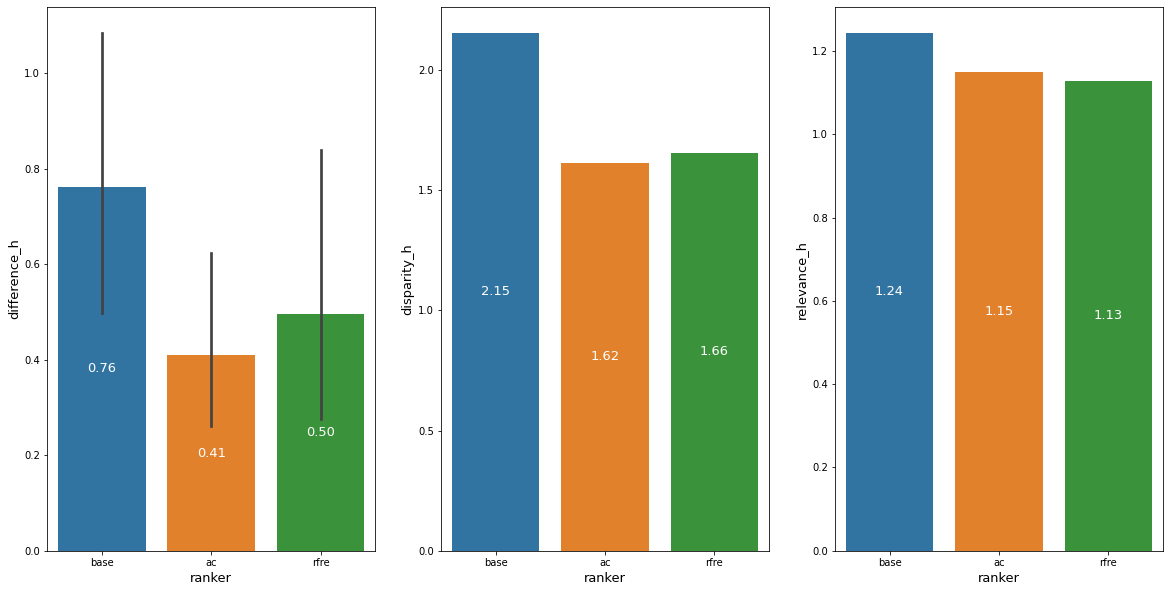

In [153]:
plot_levels_anova(anova, ppdata,'ranker','difference_h', groupby_order=['base','ac','rfre'])

#### Tukey

In [106]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=ppdata['difference_h'], groups=ppdata['ranker'], alpha=0.05)
print(tukey)


    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj   lower  upper  reject
-----------------------------------------------------------
        ac lambdamart    0.353 0.1642 -0.1073 0.8133  False
        ac        rfr   0.0862 0.8944 -0.3741 0.5464  False
lambdamart        rfr  -0.2668 0.3503 -0.7271 0.1935  False
-----------------------------------------------------------


In [107]:
ppdata.groupby('ranker').get_group('lambdamart').difference_h.mean()

0.7619148

In [155]:
# augmentation
means = ppdata.groupby('ranker')['difference_h'].mean()
m1 = means['base']
m2 = means['ac']
m3 = means['rfre']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m2, m3, ms_error))


1.3261765029691692
1.0024648988780485
0.32371160409112065


In [156]:
ci()

TypeError: ci() missing 3 required positional arguments: 'dfe', 'V', and 'num_observations'

### ERR

#### ANOVA

In [157]:
formula = "difference_i ~ C(ranker) + C(qid)"
lm = ols(formula, ppdata).fit()
lm.summary()
anova = anova_lm(lm)

anova

,df,sum_sq,mean_sq,F,PR(>F)
C(ranker),2.00000,10.20905,5.10452,53.45454,0.00000
C(qid),19.00000,4.72814,0.24885,2.60595,0.00588
Residual,38.00000,3.62873,0.09549,NaN,NaN


In [158]:
print_omegasq(anova,'ranker',20,2)
print_omegasq(anova,'qid',3,2)

omega-squared	omega-squared partial
0.54			0.84

omega-squared	omega-squared partial
0.16			0.91



#### Visualize

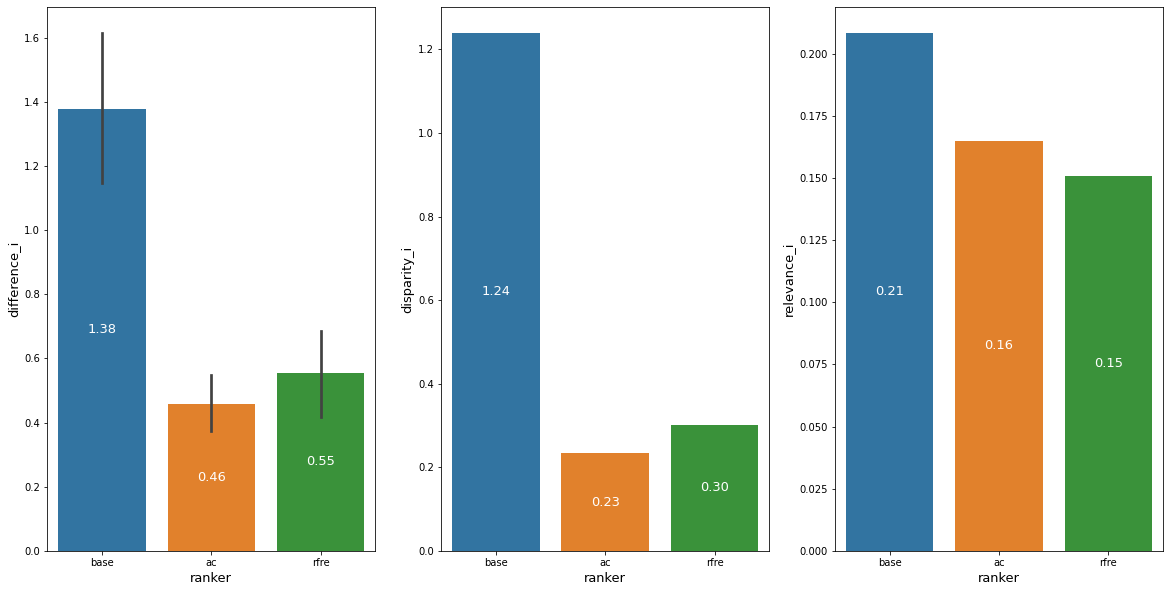

In [160]:
plot_levels_anova(anova, ppdata,'ranker','difference_i',groupby_order=['base','ac','rfre'])

#### Tukey

In [161]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=ppdata['difference_i'], groups=ppdata['ranker'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    ac   base   0.9188    0.0  0.6274  1.2101   True
    ac   rfre   0.0953 0.7126 -0.1961  0.3866  False
  base   rfre  -0.8235    0.0 -1.1149 -0.5321   True
----------------------------------------------------


In [162]:
# augmentation
means = ppdata.groupby('ranker')['difference_i'].mean()
m1 = means['base']
m2 = means['ac']
m3 = means['rfre']
ms_error = anova_lm(lm).mean_sq.loc['Residual']

print(cohens_d(m1, m2, ms_error))
print(cohens_d(m1, m3, ms_error))
print(cohens_d(m2, m3, ms_error))


2.973158761601759
2.66489464638334
0.30826411521841884


## LM with RFR

In [85]:
rfrdata = experiments.query('ranker == "rfr" and source == "lambdamart_noaug_ndcg_nofeat"')
rfrdata

,difference_h,disparity_h,relevance_h,difference_i,difference_i,relevance_i,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
67000,0.58595,2.66745,1.59743,0.76560,0.32981,0.00259,3462,rfr,lambdamart_noaug_ndcg_nofeat,author,ind,-,-,noaug,ndcg,-,-,-,author_ind
67001,0.53583,1.43582,0.89558,0.66420,0.39301,0.25589,8940,rfr,lambdamart_noaug_ndcg_nofeat,author,ind,-,-,noaug,ndcg,-,-,-,author_ind
67002,0.23273,1.96092,1.46879,0.40892,0.18634,0.06614,10795,rfr,lambdamart_noaug_ndcg_nofeat,author,ind,-,-,noaug,ndcg,-,-,-,author_ind
67003,0.16710,1.21618,0.85511,0.17401,0.11450,0.05105,12073,rfr,lambdamart_noaug_ndcg_nofeat,author,ind,-,-,noaug,ndcg,-,-,-,author_ind
67004,0.14305,1.77996,1.68474,1.09941,0.42303,0.05285,12096,rfr,lambdamart_noaug_ndcg_nofeat,author,ind,-,-,noaug,ndcg,-,-,-,author_ind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67075,0.38618,2.47630,1.60279,0.37829,0.20984,0.13627,64062,rfr,lambdamart_noaug_ndcg_nofeat,doc,-,-,-,noaug,ndcg,-,-,-,doc_-
67076,0.07816,2.55821,2.16614,0.55271,0.39464,0.31245,66637,rfr,lambdamart_noaug_ndcg_nofeat,doc,-,-,-,noaug,ndcg,-,-,-,doc_-
67077,0.20991,1.50974,1.50326,0.55891,0.39690,0.31049,67404,rfr,lambdamart_noaug_ndcg_nofeat,doc,-,-,-,noaug,ndcg,-,-,-,doc_-
67078,0.25001,1.36099,1.01830,0.54435,0.33733,0.28764,70673,rfr,lambdamart_noaug_ndcg_nofeat,doc,-,-,-,noaug,ndcg,-,-,-,doc_-


### EEL

#### ANOVA

In [57]:
formula = "difference_h ~ C(gr) + C(qid)"
lm = ols(formula, rfrdata).fit()
lm.summary()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,0.04162,0.01387,0.54987,0.65028
C(qid),19.00000,30.15118,1.58690,62.90267,0.00000
Residual,57.00000,1.43799,0.02523,NaN,NaN


### ERR

#### ANOVA

In [58]:
formula = "difference_ind ~ C(gr) + C(qid)"
lm = ols(formula, rfrdata).fit()
lm.summary()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,0.08669,0.02890,3.12262,0.03284
C(qid),19.00000,6.41730,0.33775,36.49645,0.00000
Residual,57.00000,0.52750,0.00925,NaN,NaN


In [59]:
print_omegasq(anova,'gr',20,5)
print_omegasq(anova,'qid',4,5)

omega-squared	omega-squared partial
0.00839			0.2415

omega-squared	omega-squared partial
0.88881			0.9941



#### Tukey

In [60]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=rfrdata['difference_ind'], groups=rfrdata['gr'], alpha=0.05)
print(tukey)


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
 author_ind author_none   0.0002    1.0 -0.2509 0.2513  False
 author_ind  author_one    0.003    1.0 -0.2481 0.2541  False
 author_ind       doc_-  -0.0749 0.8617  -0.326 0.1762  False
author_none  author_one   0.0029    1.0 -0.2482  0.254  False
author_none       doc_-  -0.0751 0.8609 -0.3262  0.176  False
 author_one       doc_-  -0.0779 0.8471  -0.329 0.1732  False
-------------------------------------------------------------


## LM with AC

In [417]:
aclmdata

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,source,theta,hfunc,ranker,group
0,0.18219,1.98065,1.45592,0.43733,0.17028,0.08697,3462,lambdamart_noaug_ndcg_nofeat,99.00000,linear,ac,author_ind
1,1.04109,2.17123,1.01066,0.81603,0.44864,0.20779,8940,lambdamart_noaug_ndcg_nofeat,99.00000,linear,ac,author_ind
2,0.41444,1.58361,1.18928,0.45449,0.25033,0.07535,10795,lambdamart_noaug_ndcg_nofeat,99.00000,linear,ac,author_ind
3,0.03944,0.82750,0.72461,0.10814,0.12902,0.09125,12073,lambdamart_noaug_ndcg_nofeat,99.00000,linear,ac,author_ind
4,0.29949,1.34927,1.39117,0.85356,0.35251,0.14051,12096,lambdamart_noaug_ndcg_nofeat,99.00000,linear,ac,author_ind
...,...,...,...,...,...,...,...,...,...,...,...,...
475,0.26982,2.18622,1.51593,0.37171,0.19756,0.13342,64062,lambdamart_noaug_ndcg_nofeat,9.00000,min,ac,doc
476,0.09907,2.77209,2.26262,0.51713,0.34822,0.30703,66637,lambdamart_noaug_ndcg_nofeat,9.00000,min,ac,doc
477,0.20831,1.54284,1.52061,0.57839,0.36006,0.28233,67404,lambdamart_noaug_ndcg_nofeat,9.00000,min,ac,doc
478,0.36162,1.52770,1.04585,0.55523,0.28304,0.25505,70673,lambdamart_noaug_ndcg_nofeat,9.00000,min,ac,doc


In [335]:
aclmdata = experiments.query('ranker == "ac" and source == ')

In [362]:
aclmdata.query('group == "author_none" .groupby(['group','theta','hfunc']).mean().sort_values(by='difference_ind')

difference  disparity  relevance  difference_ind  disparity_ind  \
group       theta    hfunc                                                                     
author_ind  9.00000  linear     0.39938    1.59609    1.14495         0.44910        0.22849   
doc         9.00000  linear     0.40124    1.60976    1.15086         0.45033        0.22378   
author_one  9.00000  linear     0.40018    1.59302    1.14302         0.45048        0.22856   
doc         9.00000  max        0.40161    1.61312    1.15235         0.45171        0.22445   
author_ind  9.00000  max        0.39895    1.60301    1.14863         0.45280        0.22938   
author_one  9.00000  max        0.39994    1.60303    1.14814         0.45404        0.23014   
author_none 9.00000  linear     0.40894    1.61549    1.14987         0.45901        0.23349   
                     max        0.40794    1.61882    1.15204         0.46028        0.23345   
doc         9.00000  min        0.41256    1.63148    1.15606         0.46395        0.22260   
author_ind  9.00000  min        0.40822    1.61930    1.15214         0.46460        0.22583   
author_one  9.00000  min        0.40825    1.62159    1.15327         0.46490        0.22616   
doc         99.00000 linear     0.43496    1.67959    1.16891         0.48092        0.28047   
                     max        0.43496    1.67959    1.16891         0.48092        0.28047   
author_one  99.00000 min        0.37998    1.52350    1.11836         0.48217        0.27518   
author_ind  99.00000 min        0.38239    1.52543    1.11812         0.48227        0.27522   
doc         99.00000 min        0.38763    1.53881    1.12219         0.48325        0.27302   
author_ind  99.00000 max        0.44576    1.67185    1.15964         0.48408        0.28584   
                     linear     0.44576    1.67185    1.15964         0.48408        0.28584   
author_one  99.00000 max        0.44661    1.67152    1.15905         0.48476        0.28625   
                     linear     0.44661    1.67152    1.15905         0.48476        0.28625   
author_none 99.00000 max        0.44558    1.67348    1.16055         0.48723        0.28706   
                     linear     0.44558    1.67348    1.16055         0.48723        0.28706   
                     min        0.43291    1.57596    1.11812         0.55130        0.34539   
            9.00000  min        0.52788    1.73159    1.14845         0.61524        0.36057   

                             relevance_ind         qid  
group       theta    hfunc                              
author_ind  9.00000  linear        0.16737 39200.95000  
doc         9.00000  linear        0.16440 39200.95000  
author_one  9.00000  linear        0.16671 39200.95000  
doc         9.00000  max           0.16404 39200.95000  
author_ind  9.00000  max           0.16596 39200.95000  
author_one  9.00000  max           0.16572 39200.95000  
author_none 9.00000  linear        0.16491 39200.95000  
                     max           0.16426 39200.95000  
doc         9.00000  min           0.15700 39200.95000  
author_ind  9.00000  min           0.15829 39200.95000  
author_one  9.00000  min           0.15830 39200.95000  
doc         99.00000 linear        0.17745 39200.95000  
                     max           0.17745 39200.95000  
author_one  99.00000 min           0.17418 39200.95000  
author_ind  99.00000 min           0.17415 39200.95000  
doc         99.00000 min           0.17255 39200.95000  
author_ind  99.00000 max           0.17855 39200.95000  
                     linear        0.17855 39200.95000  
author_one  99.00000 max           0.17842 39200.95000  
                     linear        0.17842 39200.95000  
author_none 99.00000 max           0.17759 39200.95000  
                     linear        0.17759 39200.95000  
                     min           0.17472 39200.95000  
            9.00000  min           0.15034 39200.95000

In [351]:
aclmdata.groupby(['group','theta','hfunc']).mean().sort_values(by='difference')

difference  disparity  relevance  difference_ind  disparity_ind  \
group       theta    hfunc                                                                     
author_one  99.00000 min        0.37998    1.52350    1.11836         0.48217        0.27518   
author_ind  99.00000 min        0.38239    1.52543    1.11812         0.48227        0.27522   
doc         99.00000 min        0.38763    1.53881    1.12219         0.48325        0.27302   
author_ind  9.00000  max        0.39895    1.60301    1.14863         0.45280        0.22938   
                     linear     0.39938    1.59609    1.14495         0.44910        0.22849   
author_one  9.00000  max        0.39994    1.60303    1.14814         0.45404        0.23014   
                     linear     0.40018    1.59302    1.14302         0.45048        0.22856   
doc         9.00000  linear     0.40124    1.60976    1.15086         0.45033        0.22378   
                     max        0.40161    1.61312    1.15235         0.45171        0.22445   
author_none 9.00000  max        0.40794    1.61882    1.15204         0.46028        0.23345   
author_ind  9.00000  min        0.40822    1.61930    1.15214         0.46460        0.22583   
author_one  9.00000  min        0.40825    1.62159    1.15327         0.46490        0.22616   
author_none 9.00000  linear     0.40894    1.61549    1.14987         0.45901        0.23349   
doc         9.00000  min        0.41256    1.63148    1.15606         0.46395        0.22260   
author_none 99.00000 min        0.43291    1.57596    1.11812         0.55130        0.34539   
doc         99.00000 max        0.43496    1.67959    1.16891         0.48092        0.28047   
                     linear     0.43496    1.67959    1.16891         0.48092        0.28047   
author_none 99.00000 max        0.44558    1.67348    1.16055         0.48723        0.28706   
                     linear     0.44558    1.67348    1.16055         0.48723        0.28706   
author_ind  99.00000 max        0.44576    1.67185    1.15964         0.48408        0.28584   
                     linear     0.44576    1.67185    1.15964         0.48408        0.28584   
author_one  99.00000 linear     0.44661    1.67152    1.15905         0.48476        0.28625   
                     max        0.44661    1.67152    1.15905         0.48476        0.28625   
author_none 9.00000  min        0.52788    1.73159    1.14845         0.61524        0.36057   

                             relevance_ind         qid  
group       theta    hfunc                              
author_one  99.00000 min           0.17418 39200.95000  
author_ind  99.00000 min           0.17415 39200.95000  
doc         99.00000 min           0.17255 39200.95000  
author_ind  9.00000  max           0.16596 39200.95000  
                     linear        0.16737 39200.95000  
author_one  9.00000  max           0.16572 39200.95000  
                     linear        0.16671 39200.95000  
doc         9.00000  linear        0.16440 39200.95000  
                     max           0.16404 39200.95000  
author_none 9.00000  max           0.16426 39200.95000  
author_ind  9.00000  min           0.15829 39200.95000  
author_one  9.00000  min           0.15830 39200.95000  
author_none 9.00000  linear        0.16491 39200.95000  
doc         9.00000  min           0.15700 39200.95000  
author_none 99.00000 min           0.17472 39200.95000  
doc         99.00000 max           0.17745 39200.95000  
                     linear        0.17745 39200.95000  
author_none 99.00000 max           0.17759 39200.95000  
                     linear        0.17759 39200.95000  
author_ind  99.00000 max           0.17855 39200.95000  
                     linear        0.17855 39200.95000  
author_one  99.00000 linear        0.17842 39200.95000  
                     max           0.17842 39200.95000  
author_none 9.00000  min           0.15034 39200.95000

### EEL

#### ANOVA

In [337]:
formula = "difference ~ C(group) + C(theta) + C(hfunc) + C(qid)"
lm = ols(formula, aclmdata).fit()
lm.summary()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(group),3.00000,0.09086,0.03029,1.75098,0.15581
C(theta),1.00000,0.01967,0.01967,1.13722,0.28681
C(hfunc),2.00000,0.00297,0.00148,0.08580,0.91779
C(qid),19.00000,79.48698,4.18353,241.85559,0.00000
Residual,454.00000,7.85312,0.01730,NaN,NaN


In [338]:
print_omegasq(anova,'qid',24,5)

omega-squared	omega-squared partial
0.90533			0.99478



### ERR

#### ANOVA

In [339]:
formula = "difference_ind ~ C(group) + C(theta) + C(hfunc) + C(qid)"
lm = ols(formula, aclmdata).fit()
lm.summary()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(group),3.00000,0.14892,0.04964,8.34212,0.00002
C(theta),1.00000,0.04663,0.04663,7.83706,0.00534
C(hfunc),2.00000,0.11005,0.05502,9.24690,0.00012
C(qid),19.00000,21.97851,1.15676,194.40091,0.00000
Residual,454.00000,2.70148,0.00595,NaN,NaN


In [340]:
print_omegasq(anova,'group',120,5)
print_omegasq(anova,'hfunc',160,5)
print_omegasq(anova,'theta',240,5)
print_omegasq(anova,'qid',24,5)

omega-squared	omega-squared partial
0.00525			0.15509

omega-squared	omega-squared partial
0.00393			0.09345

omega-squared	omega-squared partial
0.00163			0.0277

omega-squared	omega-squared partial
0.87533			0.99351



#### Tukey

In [341]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=aclmdata['difference_ind'], groups=aclmdata['group'], alpha=0.05)
print(tukey)


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
 author_ind author_none   0.0406 0.5154 -0.0355 0.1166  False
 author_ind  author_one   0.0007    1.0 -0.0753 0.0767  False
 author_ind         doc   -0.001    1.0  -0.077 0.0751  False
author_none  author_one  -0.0399 0.5304 -0.1159 0.0362  False
author_none         doc  -0.0415 0.4946 -0.1176 0.0345  False
 author_one         doc  -0.0017 0.9999 -0.0777 0.0744  False
-------------------------------------------------------------


In [342]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=aclmdata['difference_ind'], groups=aclmdata['theta'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   9.0   99.0   0.0197 0.3449 -0.0213 0.0607  False
---------------------------------------------------


In [343]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=aclmdata['difference_ind'], groups=aclmdata['hfunc'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
linear    max   0.0012 0.9987 -0.0588 0.0613  False
linear    min   0.0327 0.4063 -0.0273 0.0927  False
   max    min   0.0315 0.4342 -0.0285 0.0915  False
---------------------------------------------------


# Statistical analysis AC

## Select AC data

In [348]:
experiments

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
0,0.09399,1.76431,1.39184,0.50547,0.18796,0.06174,3462,ac,lambdamart_aug0.5_err_mpt_10_0.1,author,ind,99.00000,linear,aug0.5,err,mpt,10,0.1,author_ind
1,0.45824,1.34902,0.89097,0.86125,0.50421,0.21297,8940,ac,lambdamart_aug0.5_err_mpt_10_0.1,author,ind,99.00000,linear,aug0.5,err,mpt,10,0.1,author_ind
2,0.21175,2.20588,1.60176,0.37645,0.20089,0.08965,10795,ac,lambdamart_aug0.5_err_mpt_10_0.1,author,ind,99.00000,linear,aug0.5,err,mpt,10,0.1,author_ind
3,0.20305,1.05926,0.75869,0.26930,0.18777,0.04005,12073,ac,lambdamart_aug0.5_err_mpt_10_0.1,author,ind,99.00000,linear,aug0.5,err,mpt,10,0.1,author_ind
4,0.11957,1.87579,1.74439,0.80378,0.28136,0.12983,12096,ac,lambdamart_aug0.5_err_mpt_10_0.1,author,ind,99.00000,linear,aug0.5,err,mpt,10,0.1,author_ind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67275,0.34180,2.19984,1.48675,0.85813,1.08333,0.33309,64062,relevance_ranker,TEXT,-,-,-,-,-,-,-,-,-,-_-
67276,0.32117,3.71522,2.62314,1.88697,1.32937,0.11269,66637,relevance_ranker,TEXT,-,-,-,-,-,-,-,-,-,-_-
67277,0.01885,2.07322,1.88053,0.52595,1.08236,0.66969,67404,relevance_ranker,TEXT,-,-,-,-,-,-,-,-,-,-_-
67278,1.01241,2.37717,1.14519,2.08095,1.33333,0.01734,70673,relevance_ranker,TEXT,-,-,-,-,-,-,-,-,-,-_-


In [425]:
acdata = experiments.query('ranker == "ac" and (source == "lambdamart_noaug_ndcg_nofeat" or source == "TEXT_train" or source == "META_train")')
acdata = acdata.reset_index(drop=True)
acdata

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,ranker,source,group,subgroup,theta,hfunc,augmentation,val_metric,feature_method,num_features,balancing_factor,gr
0,0.18219,1.98065,1.45592,0.43733,0.17028,0.08697,3462,ac,lambdamart_noaug_ndcg_nofeat,author,ind,99.00000,linear,noaug,ndcg,-,-,-,author_ind
1,1.04109,2.17123,1.01066,0.81603,0.44864,0.20779,8940,ac,lambdamart_noaug_ndcg_nofeat,author,ind,99.00000,linear,noaug,ndcg,-,-,-,author_ind
2,0.41444,1.58361,1.18928,0.45449,0.25033,0.07535,10795,ac,lambdamart_noaug_ndcg_nofeat,author,ind,99.00000,linear,noaug,ndcg,-,-,-,author_ind
3,0.03944,0.82750,0.72461,0.10814,0.12902,0.09125,12073,ac,lambdamart_noaug_ndcg_nofeat,author,ind,99.00000,linear,noaug,ndcg,-,-,-,author_ind
4,0.29949,1.34927,1.39117,0.85356,0.35251,0.14051,12096,ac,lambdamart_noaug_ndcg_nofeat,author,ind,99.00000,linear,noaug,ndcg,-,-,-,author_ind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.27267,2.23038,1.53659,0.34305,0.16840,0.13317,64062,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-,doc_-
1436,0.11407,2.82126,2.27971,0.58871,0.30796,0.25111,66637,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-,doc_-
1437,0.30607,1.41376,1.40719,0.56222,0.30336,0.26206,67404,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-,doc_-
1438,0.44303,1.82916,1.15587,0.68086,0.21450,0.15797,70673,ac,TEXT_train,doc,-,9.00000,min,-,-,-,-,-,doc_-


## Grouping

### EEL

#### ANOVA A

In [482]:
acadata = acdata.query('source == "META_train" and hfunc == "linear"')

In [483]:
formula = "difference ~ C(gr) + C(theta) + C(qid)"
lm = ols(formula, acadata).fit()
lm.summary()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,0.08345,0.02782,6.96954,0.00021
C(theta),1.00000,0.00290,0.00290,0.72631,0.39558
C(qid),19.00000,41.37983,2.17789,545.69739,0.00000
Residual,136.00000,0.54278,0.00399,NaN,NaN


#### Visualize

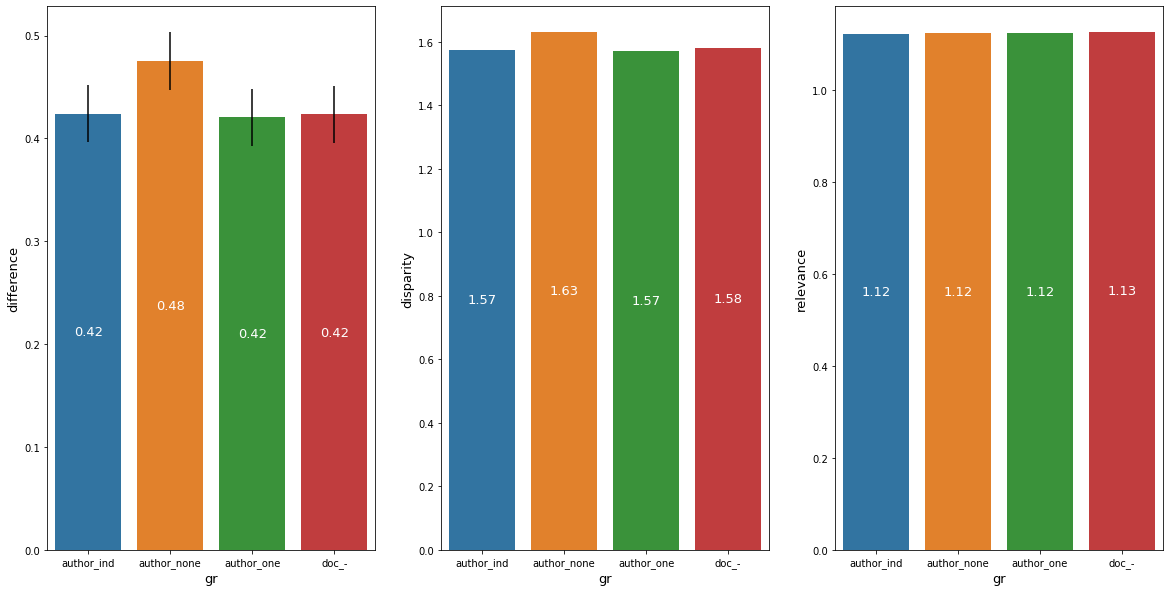

In [484]:
plot_levels_anova(anova, acadata,'gr','difference')

#### Tukey

In [485]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acadata['difference'], groups=acadata['gr'], alpha=0.05)
print(tukey)


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
 author_ind author_none   0.0512 0.9712 -0.2499 0.3522  False
 author_ind  author_one  -0.0037    1.0 -0.3047 0.2974  False
 author_ind       doc_-  -0.0008    1.0 -0.3019 0.3002  False
author_none  author_one  -0.0548 0.9649 -0.3559 0.2462  False
author_none       doc_-   -0.052 0.9699  -0.353 0.2491  False
 author_one       doc_-   0.0028    1.0 -0.2982 0.3039  False
-------------------------------------------------------------


#### ANOVA B

In [487]:
acbdata = acdata.query('source == "TEXT_train" and hfunc == "linear"')

In [488]:
formula = "difference ~ C(gr) + C(theta) + C(qid)"
lm = ols(formula, acbdata).fit()
lm.summary()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,0.23221,0.07740,6.53182,0.00037
C(theta),1.00000,0.00052,0.00052,0.04394,0.83429
C(qid),19.00000,47.12964,2.48051,209.32604,0.00000
Residual,136.00000,1.61160,0.01185,NaN,NaN


#### Visualize

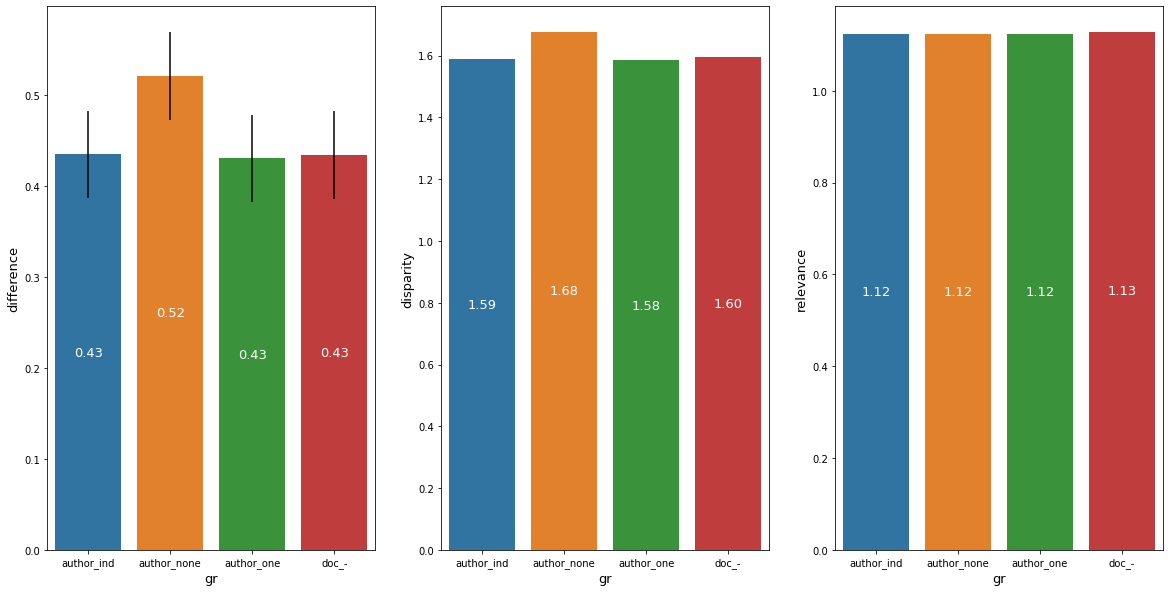

In [489]:
plot_levels_anova(anova, acbdata,'gr','difference')

#### Tukey

In [490]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acbdata['difference'], groups=acbdata['gr'], alpha=0.05)
print(tukey)


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
 author_ind author_none   0.0862  0.901 -0.2384 0.4108  False
 author_ind  author_one  -0.0045    1.0 -0.3291 0.3201  False
 author_ind       doc_-  -0.0007    1.0 -0.3253 0.3239  False
author_none  author_one  -0.0907 0.8868 -0.4153 0.2339  False
author_none       doc_-  -0.0868  0.899 -0.4114 0.2378  False
 author_one       doc_-   0.0038    1.0 -0.3207 0.3284  False
-------------------------------------------------------------


### ERR

#### ANOVA A

In [491]:
formula = "difference_ind ~ C(gr) + C(theta) + C(qid)"
lm = ols(formula, acadata).fit()
lm.summary()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,0.06471,0.02157,11.96449,0.00000
C(theta),1.00000,0.00355,0.00355,1.96813,0.16293
C(qid),19.00000,7.24668,0.38140,211.54379,0.00000
Residual,136.00000,0.24520,0.00180,NaN,NaN


#### Visualize

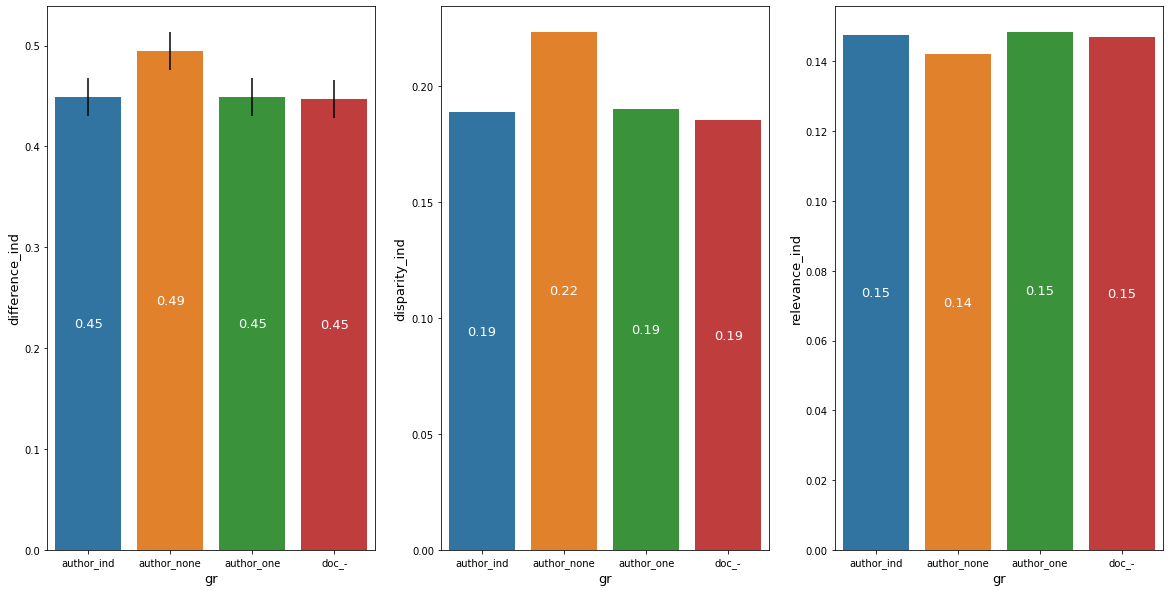

In [492]:
plot_levels_anova(anova, acadata,'gr','difference_ind')

#### Tukey

In [494]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acadata['difference_ind'], groups=acadata['gr'], alpha=0.05)
print(tukey)


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
 author_ind author_none   0.0457 0.7876 -0.0816  0.173  False
 author_ind  author_one     -0.0    1.0 -0.1273 0.1273  False
 author_ind       doc_-  -0.0021    1.0 -0.1294 0.1252  False
author_none  author_one  -0.0457 0.7874  -0.173 0.0816  False
author_none       doc_-  -0.0478 0.7637 -0.1751 0.0795  False
 author_one       doc_-  -0.0021    1.0 -0.1294 0.1252  False
-------------------------------------------------------------


#### ANOVA B

In [496]:
formula = "difference_ind ~ C(gr) + C(theta) + C(qid)"
lm = ols(formula, acbdata).fit()
lm.summary()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(gr),3.00000,0.18309,0.06103,9.89165,0.00001
C(theta),1.00000,0.00008,0.00008,0.01329,0.90841
C(qid),19.00000,8.75771,0.46093,74.70566,0.00000
Residual,136.00000,0.83912,0.00617,NaN,NaN


#### Visualize

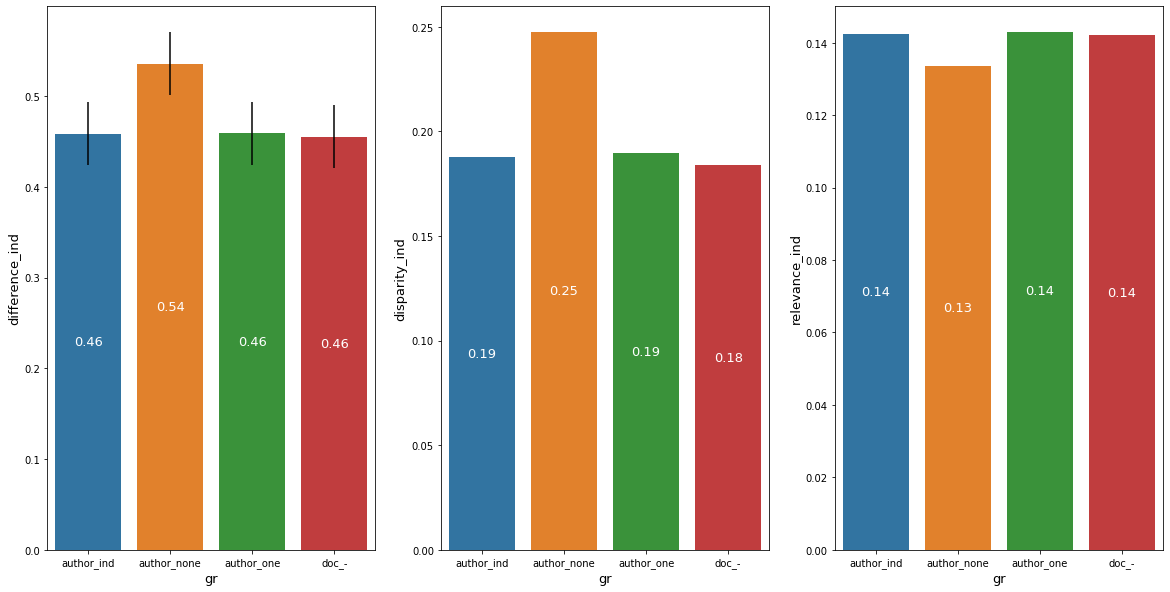

In [497]:
plot_levels_anova(anova, acbdata,'gr','difference_ind')

#### Tukey

In [498]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acbdata['difference_ind'], groups=acbdata['gr'], alpha=0.05)
print(tukey)


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
 author_ind author_none   0.0773 0.5052 -0.0667 0.2213  False
 author_ind  author_one   0.0007    1.0 -0.1433 0.1448  False
 author_ind       doc_-   -0.003 0.9999  -0.147  0.141  False
author_none  author_one  -0.0766 0.5134 -0.2206 0.0675  False
author_none       doc_-  -0.0803 0.4716 -0.2243 0.0637  False
 author_one       doc_-  -0.0037 0.9999 -0.1478 0.1403  False
-------------------------------------------------------------


## hfunc

### EEL

#### ANOVA A

In [499]:
acadata = acdata.query('source == "META_train" and gr == "author_none"')

In [500]:
formula = "difference ~ C(hfunc) + C(theta) + C(qid)"
lm = ols(formula, acadata).fit()
lm.summary()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(hfunc),2.00000,0.42566,0.21283,9.44690,0.00018
C(theta),1.00000,0.07899,0.07899,3.50603,0.06416
C(qid),19.00000,47.51412,2.50074,111.00112,0.00000
Residual,97.00000,2.18531,0.02253,NaN,NaN


#### Visualize

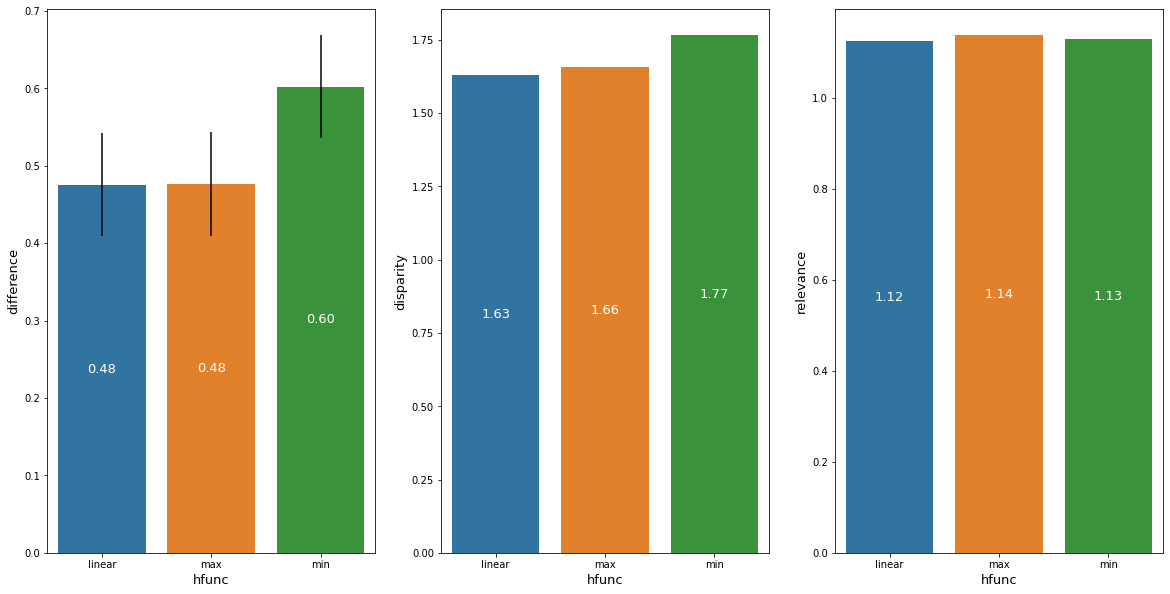

In [501]:
plot_levels_anova(anova, acadata,'hfunc','difference')

#### Tukey

In [502]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acadata['difference'], groups=acadata['hfunc'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
linear    max    0.001    1.0 -0.3452 0.3473  False
linear    min   0.1269 0.6604 -0.2194 0.4731  False
   max    min   0.1258 0.6648 -0.2204 0.4721  False
---------------------------------------------------


#### ANOVA B

In [503]:
acadata = acdata.query('source == "TEXT_train" and gr == "author_none"')

In [504]:
formula = "difference ~ C(hfunc) + C(theta) + C(qid)"
lm = ols(formula, acadata).fit()
lm.summary()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(hfunc),2.00000,0.22266,0.11133,6.59813,0.00206
C(theta),1.00000,0.03076,0.03076,1.82281,0.18012
C(qid),19.00000,58.75734,3.09249,183.28190,0.00000
Residual,97.00000,1.63667,0.01687,NaN,NaN


#### Visualize

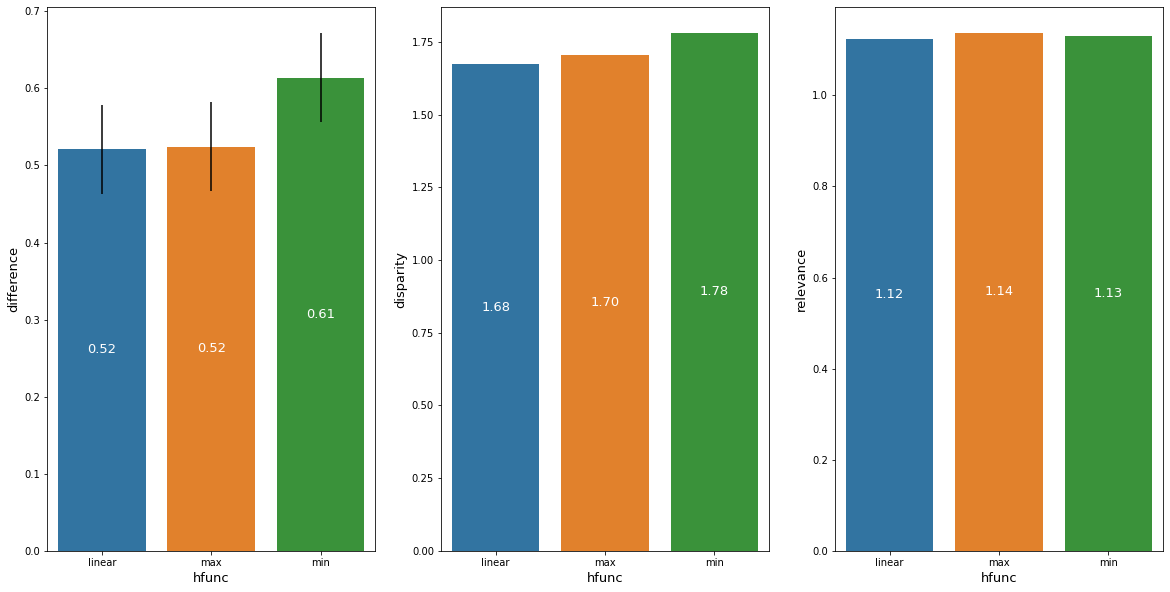

In [505]:
plot_levels_anova(anova, acadata,'hfunc','difference')

#### Tukey

In [506]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acadata['difference'], groups=acadata['hfunc'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
linear    max   0.0033 0.9998 -0.3782 0.3848  False
linear    min    0.093 0.8318 -0.2885 0.4745  False
   max    min   0.0897 0.8425 -0.2918 0.4712  False
---------------------------------------------------


### ERR

#### ANOVA A

In [507]:
acadata = acdata.query('source == "META_train" and gr == "author_none"')

In [508]:
formula = "difference_ind ~ C(hfunc) + C(theta) + C(qid)"
lm = ols(formula, acadata).fit()
lm.summary()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(hfunc),2.00000,0.39345,0.19673,12.17208,0.00002
C(theta),1.00000,0.07669,0.07669,4.74533,0.03180
C(qid),19.00000,8.08932,0.42575,26.34256,0.00000
Residual,97.00000,1.56773,0.01616,NaN,NaN


#### Visualize

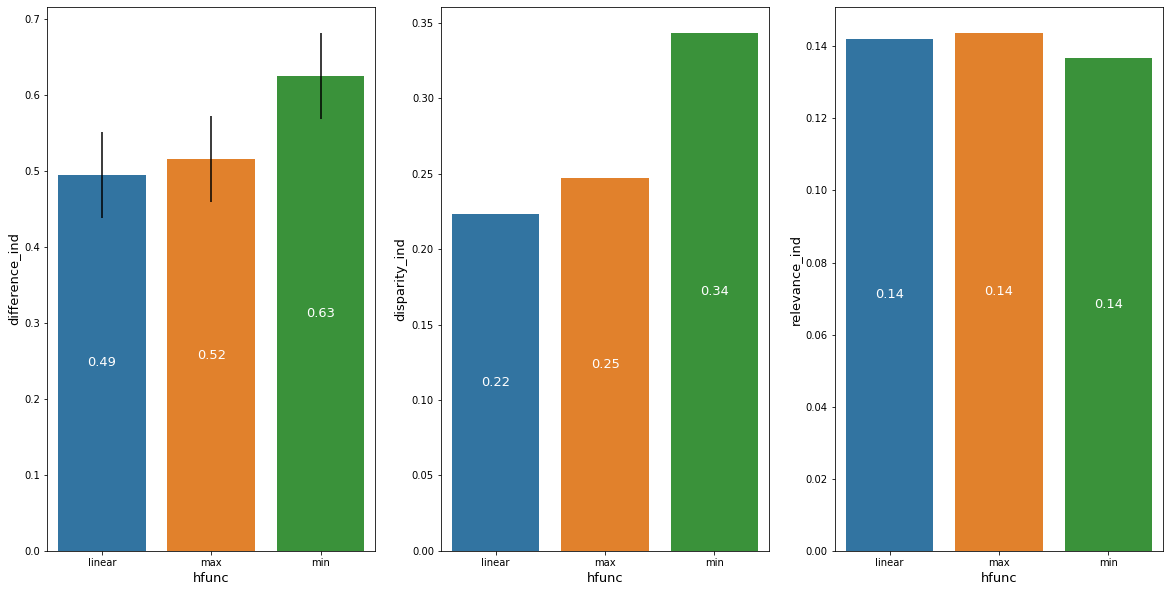

In [509]:
plot_levels_anova(anova, acadata,'hfunc','difference_ind')

#### Tukey

In [510]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acadata['difference_ind'], groups=acadata['hfunc'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
linear    max   0.0208 0.9442 -0.1323 0.1739  False
linear    min   0.1305  0.111 -0.0226 0.2836  False
   max    min   0.1097 0.2091 -0.0434 0.2628  False
---------------------------------------------------


#### ANOVA B

In [511]:
acadata = acdata.query('source == "TEXT_train" and gr == "author_none"')

In [512]:
formula = "difference_ind ~ C(hfunc) + C(theta) + C(qid)"
lm = ols(formula, acadata).fit()
lm.summary()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(hfunc),2.00000,0.20673,0.10336,6.19514,0.00294
C(theta),1.00000,0.02097,0.02097,1.25697,0.26499
C(qid),19.00000,11.52427,0.60654,36.35314,0.00000
Residual,97.00000,1.61841,0.01668,NaN,NaN


#### Visualize

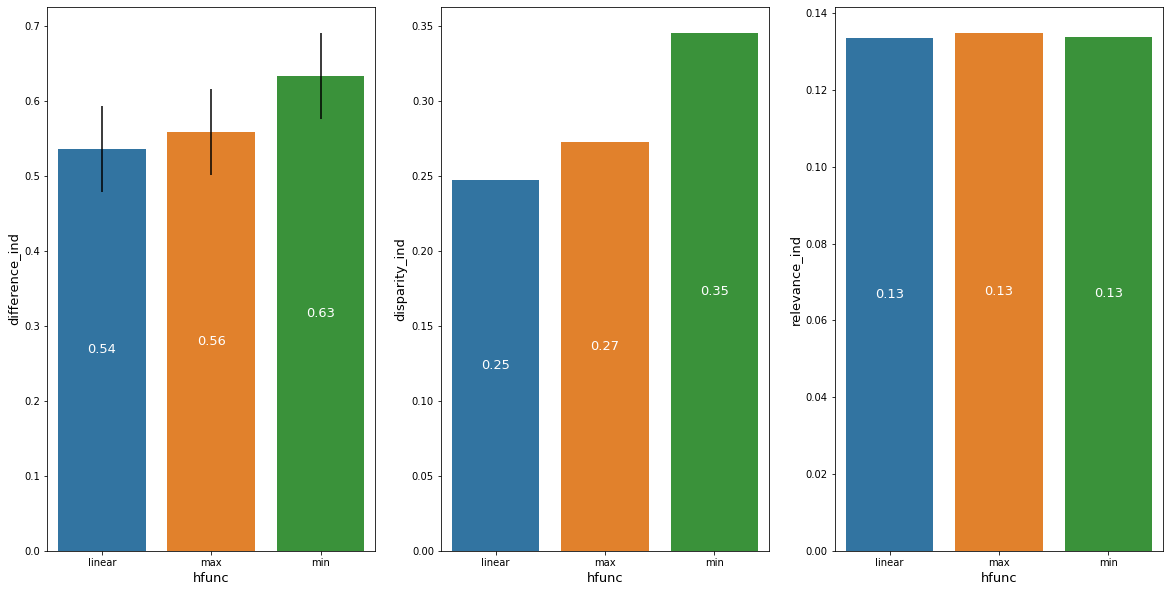

In [513]:
plot_levels_anova(anova, acadata,'hfunc','difference_ind')

#### Tukey

In [514]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acadata['difference_ind'], groups=acadata['hfunc'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
linear    max   0.0231 0.9492  -0.155 0.2011  False
linear    min   0.0973 0.3997 -0.0808 0.2753  False
   max    min   0.0742 0.5849 -0.1038 0.2523  False
---------------------------------------------------


## source

### EEL

#### ANOVA A

In [515]:
acadata = acdata.query('gr == "author_none" and hfunc == "linear"')

In [516]:
formula = "difference ~ C(source) + C(theta) + C(qid)"
lm = ols(formula, acadata).fit()
lm.summary()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(source),2.00000,0.17616,0.08808,1.82071,0.16740
C(theta),1.00000,0.00121,0.00121,0.02497,0.87478
C(qid),19.00000,33.37127,1.75638,36.30627,0.00000
Residual,97.00000,4.69255,0.04838,NaN,NaN


#### Visualize

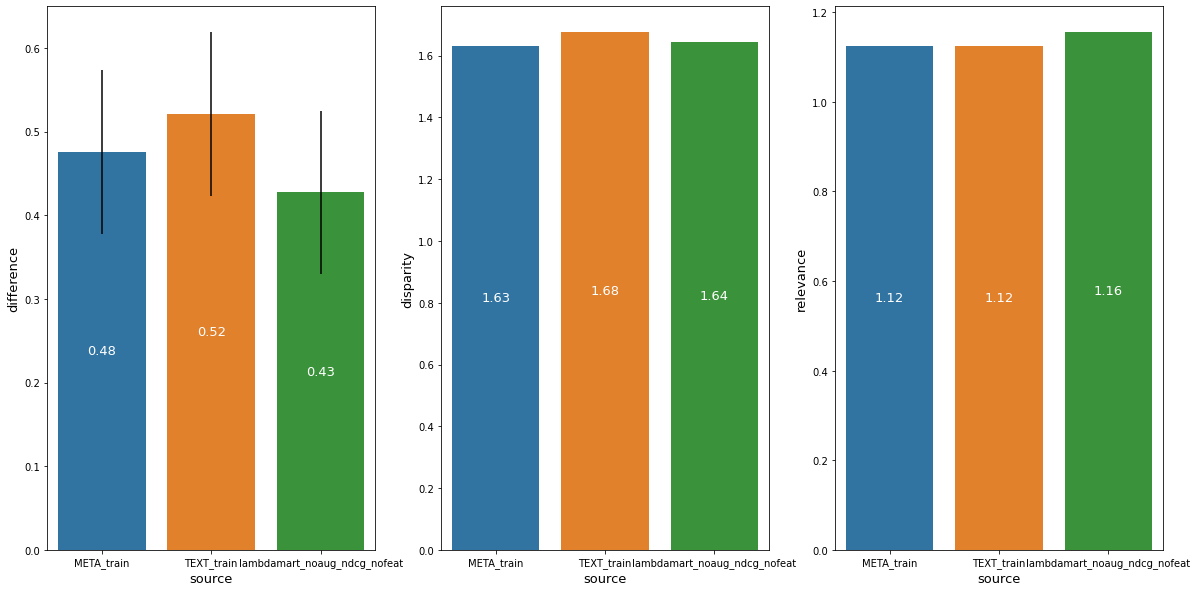

In [517]:
plot_levels_anova(anova, acadata,'source','difference')

### ERR

#### ANOVA A

In [518]:
formula = "difference_ind ~ C(source) + C(theta) + C(qid)"
lm = ols(formula, acadata).fit()
lm.summary()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(source),2.00000,0.08066,0.04033,4.48520,0.01371
C(theta),1.00000,0.00059,0.00059,0.06555,0.79847
C(qid),19.00000,7.45792,0.39252,43.65301,0.00000
Residual,97.00000,0.87221,0.00899,NaN,NaN


#### Visualize

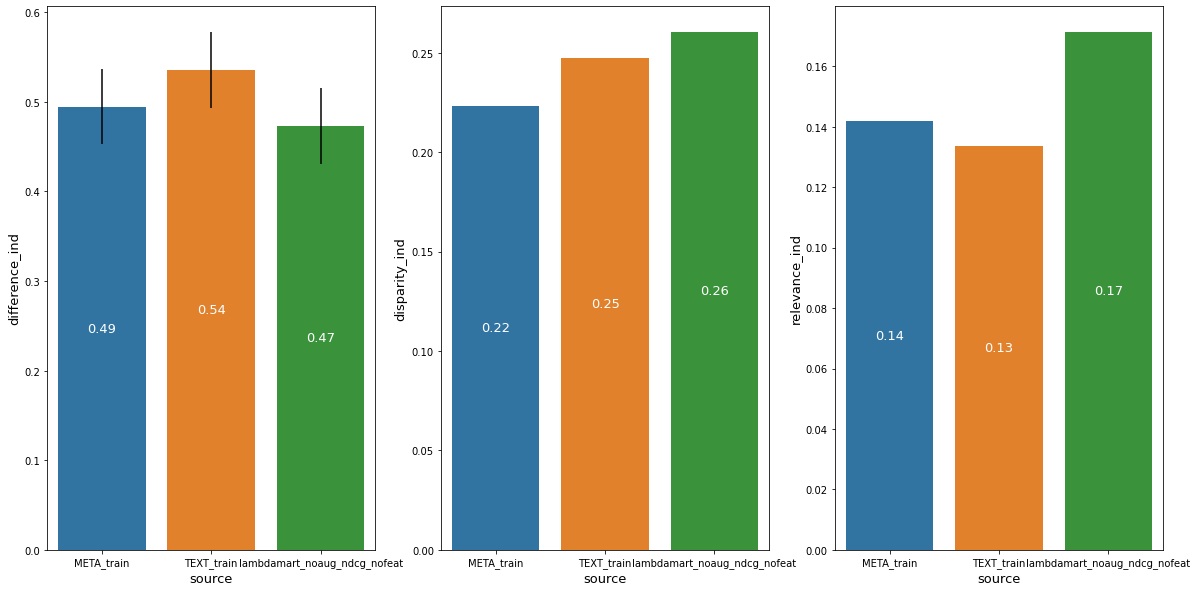

In [519]:
plot_levels_anova(anova, acadata,'source','difference_ind')

#### Tukey

In [520]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=acadata['difference_ind'], groups=acadata['source'], alpha=0.05)
print(tukey)


             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
  group1              group2            meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------------
META_train                   TEXT_train   0.0411 0.7704 -0.1005 0.1828  False
META_train lambdamart_noaug_ndcg_nofeat  -0.0214 0.9318  -0.163 0.1203  False
TEXT_train lambdamart_noaug_ndcg_nofeat  -0.0625 0.5488 -0.2041 0.0792  False
-----------------------------------------------------------------------------
